# License

***

Copyright 2018 Lingyao Meng (danielle@h2o.ai), J. Patrick Hall (phall@h2o.ai), and the H2O.ai team. 

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:
The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

# Imports and Setup

***

In [1]:
import os
import time
import sys

from data_maker_and_getter import DataMakerAndGetter
import eli5
import eli5.xgboost
import h2o
from lime_explainer import LIMEExplainer
import matplotlib.pyplot as plt
import numpy as np
from numpy import loadtxt
import pandas as pd
import shap
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

In [2]:
%matplotlib inline

In [3]:
# load JS visualization code to notebook
shap.initjs() 

In [4]:
h2o.init(max_mem_size='12G')
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,6 hours 48 mins
H2O cluster version:,3.16.0.4
H2O cluster version age:,3 months and 13 days !!!
H2O cluster name:,H2O_from_python_phall_j2s2ju
H2O cluster total nodes:,1
H2O cluster free memory:,10.27 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"
H2O connection url:,http://localhost:54321
H2O connection proxy:,None


# Known Signal Generating Function

***

The objective of this notebook is to test and compare local explanations created by the popular methods: LIME, Treeinterpreter, and Shapley on an XGBoost model trained on a known signal generating function: 

$$y = x_1 * x_4 + |x_8| * (x_9)^2$$

In this notebook we allow XGBoost to train until it has a very exact fit to the dataset containing the signal generating function.

# Data Generation and XGBoost Training
***

In [5]:
ds_ = DataMakerAndGetter(nrows=200000, target='binary', one_function = True)
rsotrain = ds_.make_random_with_signal()

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [6]:
y = 'target'
X = [name for name in rsotrain.columns if name not in [y,'row_id','function','cat1','cat2','cat3']]
print(X)

['num1', 'num2', 'num3', 'num4', 'num5', 'num6', 'num7', 'num8', 'num9', 'num10', 'num11', 'num12']


In [7]:
rsotrain[y] = rsotrain[y].asfactor()

In [8]:
rsotrain_pd = rsotrain.as_data_frame()

In [9]:
rsotrain_dm = xgb.DMatrix(rsotrain_pd[X],
                          rsotrain_pd[y])

In [10]:
ave_y = rsotrain_pd['target'].mean()
print(ave_y)

0.36422


In [11]:
params = {
     'base_score': ave_y,
     'booster': 'gbtree',
     'colsample_bytree': 0.9,
     'eta': 0.01,
     'eval_metric': 'auc',
     'max_depth': 18,
     'nthread': 4,
     'objective': 'binary:logistic',
     'reg_alpha': 0.01,
     'reg_lambda': 0.001,
     'seed': 12345,
     'silent': 0,
     'subsample': 0.1}

watchlist = [(rsotrain_dm, 'train')]

rso_model = xgb.train(params, 
                      rsotrain_dm, 
                      400,
                      evals=watchlist, 
                      verbose_eval=True)

[0]	train-auc:0.966586
[1]	train-auc:0.960032
[2]	train-auc:0.979246
[3]	train-auc:0.9759
[4]	train-auc:0.983821
[5]	train-auc:0.980889
[6]	train-auc:0.978299
[7]	train-auc:0.98375
[8]	train-auc:0.981655
[9]	train-auc:0.980703
[10]	train-auc:0.984221
[11]	train-auc:0.984251
[12]	train-auc:0.986853
[13]	train-auc:0.98597
[14]	train-auc:0.984946
[15]	train-auc:0.987291
[16]	train-auc:0.98647
[17]	train-auc:0.988451
[18]	train-auc:0.987634
[19]	train-auc:0.989085
[20]	train-auc:0.990233
[21]	train-auc:0.991281
[22]	train-auc:0.99203
[23]	train-auc:0.991473
[24]	train-auc:0.99216
[25]	train-auc:0.99166
[26]	train-auc:0.992349
[27]	train-auc:0.992878
[28]	train-auc:0.993304
[29]	train-auc:0.993034
[30]	train-auc:0.993409
[31]	train-auc:0.994191
[32]	train-auc:0.994466
[33]	train-auc:0.995039
[34]	train-auc:0.994765
[35]	train-auc:0.995301
[36]	train-auc:0.99545
[37]	train-auc:0.995832
[38]	train-auc:0.995964
[39]	train-auc:0.996061
[40]	train-auc:0.996167
[41]	train-auc:0.996242
[42]	train-

# Global Variable Importance 

***

#### XGBoost variable importance

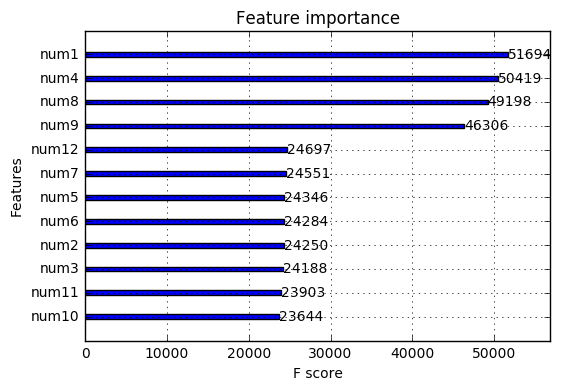

In [12]:
_ = plot_importance(rso_model)

#### Eli5/Tree Interpreter variable importance

In [13]:
eli5.show_weights(rso_model)

Weight,Feature
0.2036,num9
0.1781,num4
0.1656,num1
0.1284,num8
0.0412,num11
0.0409,num6
0.0408,num2
0.0406,num5
0.0405,num10
0.0405,num7


#### Shapley variable importance

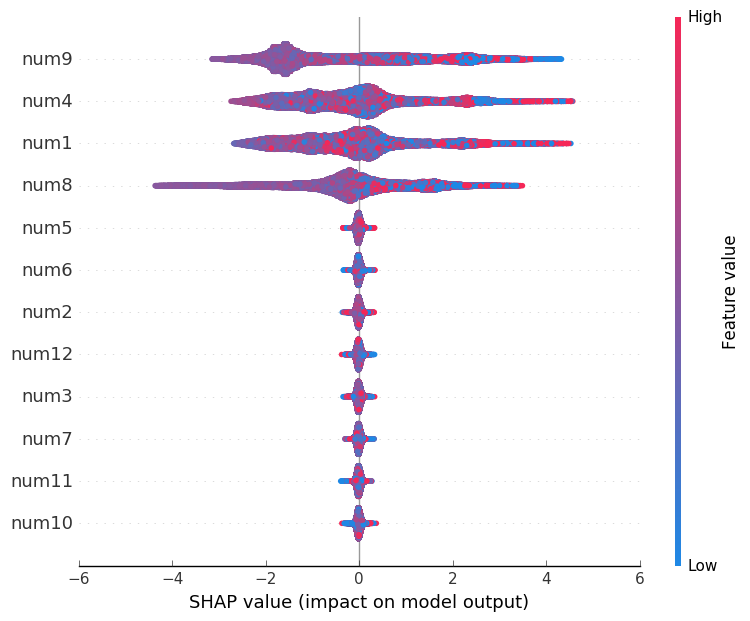

In [14]:
shap_values = rso_model.predict(rsotrain_dm, pred_contribs=True)
shap.summary_plot(shap_values, rsotrain_pd[X])

#### Example Shapley dependence (you can try other variables)

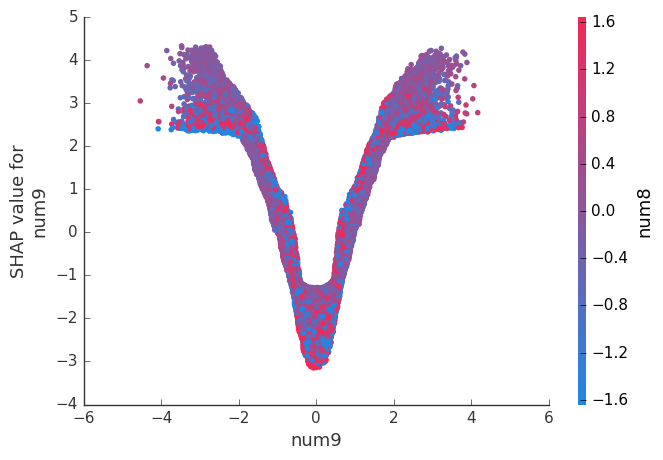

In [15]:
var = "num9" 
shap.dependence_plot(var, shap_values, rsotrain_pd[X])

# Local Explanations (variable importance) at Several Percentiles of Model Predictions

***

#### Bind XGBoost predictions to training data

In [16]:
rso_preds = pd.DataFrame(rso_model.predict(rsotrain_dm))

In [17]:
rso_decile_frame = pd.concat([rsotrain_pd, rso_preds], axis=1)
rso_decile_frame = rso_decile_frame.rename(columns={0: 'predict'})
rso_decile_hframe = h2o.H2OFrame(rso_decile_frame)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [18]:
rso_decile_frame.head()

,num1,num2,num3,num4,num5,num6,num7,num8,num9,num10,num11,num12,cat1,cat2,cat3,target,row_id,function,predict
0,-0.204708,0.478943,-0.519439,-0.555730,1.965781,1.393406,0.092908,0.281746,0.769023,1.246435,1.007189,-1.296221,AAAAAAAA,AAAAAAAA,GGGGGGGG,0,0,1,0.024026
1,0.274992,0.228913,1.352917,0.886429,-2.001637,-0.371843,1.669025,-0.438570,-0.539741,0.476985,3.248944,-1.021228,GGGGGGGG,CCCCCCCC,BBBBBBBB,0,1,1,0.029914
2,-0.577087,0.124121,0.302614,0.523772,0.000940,1.343810,-0.713544,-0.831154,-2.370232,-1.860761,-0.860757,0.560145,EEEEEEEE,BBBBBBBB,CCCCCCCC,1,2,1,0.966940
3,-1.265934,0.119827,-1.063512,0.332883,-2.359419,-0.199543,-1.541996,-0.970736,-1.307030,0.286350,0.377984,-0.753887,AAAAAAAA,GGGGGGGG,CCCCCCCC,1,3,1,0.878123
4,0.331286,1.349742,0.069877,0.246674,-0.011862,1.004812,1.327195,-0.919262,-1.549106,0.022185,0.758363,-0.660524,DDDDDDDD,AAAAAAAA,DDDDDDDD,1,4,1,0.972507


#### Find percentiles of XGBoost predictions

In [19]:
rso_percentile_dict = ds_.get_percentile_dict('predict', 'row_id', rso_decile_hframe)

In [20]:
rso_percentile_dict

{0: 36425,
 10: 78667,
 20: 117222,
 30: 176287,
 40: 53067,
 50: 51970,
 60: 160378,
 70: 197450,
 80: 148454,
 90: 174235,
 99: 175045}

# Explanation at each decile

#### Utility functions that displays the expected contribution of relevant variables with a short description at the chosen decile

In [21]:
def get_decile_describe(decile):
    
    row = rso_decile_frame[rso_decile_frame['row_id'] == rso_percentile_dict[decile]]
    print("This is the %dth decile of the predicted value with row_id %d, target %d, and prediction %.2f Base value: %.2f " 
          % (decile,row['row_id'].item(),row['target'].item(),row['predict'].item(), shap_values[row.index[0],:][-1]))
    print ("Signal generation function 1")
    return print_function1_contribs(row)
    
def print_function1_contribs(row):
    
    num1_contrib = row['num1'].iloc[0]
    print('Expected num1 contribution:', num1_contrib)
    
    num4_contrib = row['num4'].iloc[0]
    print('Expected num4 contribution:', num4_contrib)
    
    num8_contrib = np.abs(row['num8'].iloc[0]) 
    print('Expected num8 contribution:', num8_contrib)
    
    num9_contrib = np.power(row['num9'].iloc[0], 2)
    print('Expected num9 contribution:', num9_contrib)

#### Utility function that displays the TreeInterpreter plot at the chosen decile 

In [22]:
def eli5_dd(decile):
    row = rso_decile_frame[rso_decile_frame['row_id'] == rso_percentile_dict[decile]]
    return eli5.explain_prediction_xgboost(rso_model, row[X].iloc[0])

#### Utility function that displays the LIME result at the choosen decile

In [23]:
# learn what to discretize from var imp 
explainer = LIMEExplainer(training_frame=rsotrain_pd, X=X, model=rso_model, discretize=['num1', 'num4', 'num8', 'num9'])

def lime(decile):
    row = rso_decile_frame[rso_decile_frame['row_id'] == rso_percentile_dict[decile]]
    explainer.explain(row.index[0]) 

##  10th decile of model predictions

In [24]:
decile = 10
row = rso_decile_frame[rso_decile_frame['row_id'] == rso_percentile_dict[decile]]
get_decile_describe(decile)

This is the 10th decile of the predicted value with row_id 78667, target 0, and prediction 0.01 Base value: -0.45 
Signal generation function 1
Expected num1 contribution: 0.631874643341
Expected num4 contribution: -0.634565380982
Expected num8 contribution: 0.241339395507
Expected num9 contribution: 0.082215031649


### Shapley values

       Approximate Local Contributions
num1                         -1.059501
num2                         -0.027140
num3                         -0.037636
num4                         -0.805935
num5                         -0.057483
num6                          0.031907
num7                          0.059921
num8                         -0.424154
num9                         -1.595577
num10                        -0.017026
num11                        -0.010750
num12                         0.066652 

Shapley sum:  -4.32681
Model prediction:  -4.32681083965


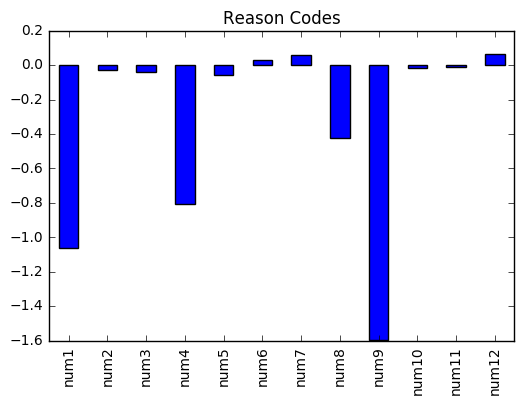

In [25]:
s_df = pd.DataFrame(shap_values[row.index[0], :][:-1].reshape(12, 1), columns=['Approximate Local Contributions'], index=X)
print(s_df, '\n')
_= s_df.plot(kind='bar', title='Reason Codes', legend=False)
print('Shapley sum: ', s_df['Approximate Local Contributions'].sum() + shap_values[row.index[0], -1])
p = row['predict'].values[0]
print('Model prediction: ', np.log(p/(1 - p)))

### TreeInterpreter

In [26]:
eli5_dd(decile)

Explanation(estimator='<xgboost.core.Booster object at 0x12b9a8860>', description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does show how increasing or decreasing\n   the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=0.10700415984045455, std=None, value=1.0), FeatureWeight(feature='num12', weight=0.06665230790203823, std=None, value=-1.8064328883320555), FeatureWeight(feature='num7', weight=0.059921012413894699, std=None, value=0.2253013855665417), FeatureWeight(feature='num6', weight=0.031907398045069285, std=None, value=0.68733042204370132)], neg=[FeatureWeight(feature='num9', weight=-1.5955775176144384, std=None, value=0.28673163698662685), FeatureWeight(feature='num1', weight=-1.0595018175931461, std=None, value=0.63187464334092414), FeatureWeight(feature='num4', weight=-0.80593412763159966, std=None, value=-0.63456538098237214), FeatureWeight(feature='num8', weight=-0.4241540466331436, std=None, value=-0.2413393955074756), FeatureWeight(feature='num5', weight=-0.057482736335726314, std=None, value=-0.45353864540512179), FeatureWeight(feature='num3', weight=-0.037635723994242885, std=None, value=0.18494543074818151), FeatureWeight(feature='num2', weight=-0.027139804431160104, std=None, value=0.10807737897476312), FeatureWeight(feature='num10', weight=-0.017025877640449962, std=None, value=-0.098775357818766202), FeatureWeight(feature='num11', weight=-0.010750040547549054, std=None, value=-0.15970505375499133)], pos_remaining=0, neg_remaining=0), proba=None, score=-3.7697168142200024, weighted_spans=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None)

In [27]:
p = row['predict'].values[0]
print('\nModel prediction: ', np.log(p/(1 - p)))


Model prediction:  -4.32681083965


### LIME


Model Prediction: 0.01
Local GLM Prediction: 0.04
Local GLM R-square: 0.72
Local GLM Intercept: 0.39

Approximate Local Contributions:
                   Input  Local Contribution
0    num1.(0.621, 1.301]           -0.087049
1  num4.(-0.645, 0.0352]           -0.085003
2   num8.(-0.252, 0.425]           -0.083576
3    num9.(0.276, 0.956]           -0.082660
4                   num2           -0.005087
5                   num3           -0.003140
6                   num6           -0.001408
7                   num7           -0.000077
8                  num10            0.000006
9                   num5            0.003021
None


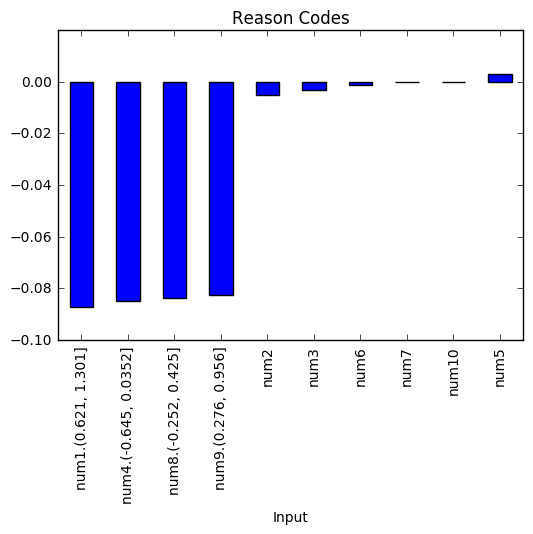

In [28]:
lime(decile)

##  Median of predictions

In [29]:
decile = 50
row = rso_decile_frame[rso_decile_frame['row_id'] == rso_percentile_dict[decile]]
get_decile_describe(decile)

This is the 50th decile of the predicted value with row_id 51970, target 0, and prediction 0.05 Base value: -0.45 
Signal generation function 1
Expected num1 contribution: 0.995146657822
Expected num4 contribution: -2.13002091866
Expected num8 contribution: 1.95169193469
Expected num9 contribution: 0.213371645125


### Shapley values

       Approximate Local Contributions
num1                         -0.755241
num2                          0.139677
num3                         -0.011096
num4                         -0.854446
num5                         -0.014329
num6                         -0.024493
num7                          0.003963
num8                          0.587400
num9                         -1.506480
num10                        -0.006720
num11                        -0.026318
num12                        -0.007124 

Shapley sum:  -2.9253
Model prediction:  -2.92529909963


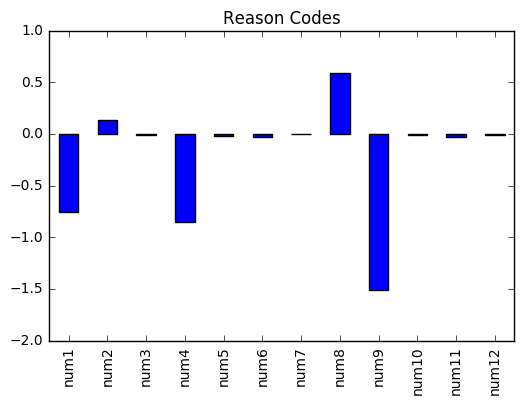

In [30]:
s_df = pd.DataFrame(shap_values[row.index[0], :][:-1].reshape(12, 1), columns=['Approximate Local Contributions'], index=X)
print(s_df, '\n')
_= s_df.plot(kind='bar', title='Reason Codes', legend=False)
print('Shapley sum: ', s_df['Approximate Local Contributions'].sum() + shap_values[row.index[0], -1])
p = row['predict'].values[0]
print('Model prediction: ', np.log(p/(1 - p)))

### TreeInterpreter 

In [31]:
eli5_dd(decile)

Explanation(estimator='<xgboost.core.Booster object at 0x12b9a8860>', description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does show how increasing or decreasing\n   the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='num8', weight=0.58739953218523389, std=None, value=-1.9516919346906001), FeatureWeight(feature='num2', weight=0.13967716895521942, std=None, value=2.6311104620600982), FeatureWeight(feature='<BIAS>', weight=0.10700415984045455, std=None, value=1.0), FeatureWeight(feature='num7', weight=0.0039625357761907736, std=None, value=-2.455343466966021)], neg=[FeatureWeight(feature='num9', weight=-1.5064805364892317, std=None, value=0.46192168722093818), FeatureWeight(feature='num4', weight=-0.85444599746317473, std=None, value=-2.1300209186645271), FeatureWeight(feature='num1', weight=-0.7552412239344134, std=None, value=0.99514665782201217), FeatureWeight(feature='num11', weight=-0.026318276470807159, std=None, value=-0.98863760713085458), FeatureWeight(feature='num6', weight=-0.024492899676074376, std=None, value=0.2035693278028422), FeatureWeight(feature='num5', weight=-0.014328825334958304, std=None, value=-0.34621204546181328), FeatureWeight(feature='num3', weight=-0.011096430657200831, std=None, value=0.58727112940044224), FeatureWeight(feature='num12', weight=-0.0071236400772330555, std=None, value=-0.036644304112277405), FeatureWeight(feature='num10', weight=-0.0067200146540082537, std=None, value=0.81004202654021917)], pos_remaining=0, neg_remaining=0), proba=None, score=-2.368204448000001, weighted_spans=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None)

In [32]:
p = row['predict'].values[0]
print('\nModel prediction: ', np.log(p/(1 - p)))


Model prediction:  -2.92529909963


### LIME


Model Prediction: 0.05
Local GLM Prediction: 0.15
Local GLM R-square: 0.58
Local GLM Intercept: 0.42

Approximate Local Contributions:
                    Input  Local Contribution
0                    num2           -0.152699
1     num1.(0.985, 1.665]           -0.036917
2    num4.(-2.141, -1.46]           -0.035048
3   num8.(-1.962, -1.285]           -0.033722
4     num9.(0.451, 1.131]           -0.032718
5                    num3           -0.015768
6                   num10           -0.008359
7                    num6           -0.002838
8                   num12            0.000275
9                    num5            0.006131
10                  num11            0.008627
11                   num7            0.029559
None


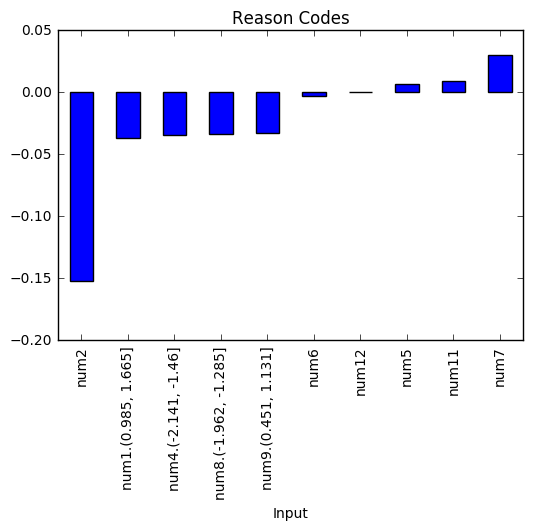

In [33]:
lime(decile)

##  90th decile of model predictions

In [34]:
decile = 90
row = rso_decile_frame[rso_decile_frame['row_id'] == rso_percentile_dict[decile]]
get_decile_describe(decile)

This is the 90th decile of the predicted value with row_id 174235, target 1, and prediction 0.96 Base value: -0.45 
Signal generation function 1
Expected num1 contribution: 1.63719684486
Expected num4 contribution: 1.77238475467
Expected num8 contribution: 1.29391324747
Expected num9 contribution: 0.86117262131


### Shapley values

       Approximate Local Contributions
num1                          1.310132
num2                         -0.012059
num3                          0.020634
num4                          1.212350
num5                         -0.082304
num6                          0.018432
num7                          0.110771
num8                          0.985901
num9                          0.021735
num10                         0.017608
num11                         0.035274
num12                         0.057633 

Shapley sum:  3.24602
Model prediction:  3.24601682702


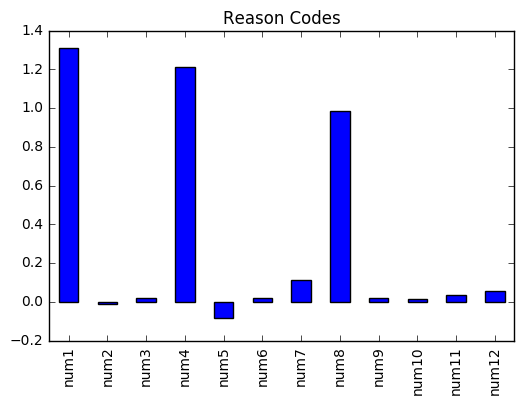

In [35]:
s_df = pd.DataFrame(shap_values[row.index[0], :][:-1].reshape(12, 1), columns=['Approximate Local Contributions'], index=X)
print(s_df, '\n')
_= s_df.plot(kind='bar', title='Reason Codes', legend=False)
print('Shapley sum: ', s_df['Approximate Local Contributions'].sum() + shap_values[row.index[0], -1])
p = row['predict'].values[0]
print('Model prediction: ', np.log(p/(1 - p)))

### TreeInterpreter

In [36]:
eli5_dd(decile)

Explanation(estimator='<xgboost.core.Booster object at 0x12b9a8860>', description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does show how increasing or decreasing\n   the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='num1', weight=1.3101316599891066, std=None, value=1.6371968448596599), FeatureWeight(feature='num4', weight=1.2123499123825012, std=None, value=1.7723847546707163), FeatureWeight(feature='num8', weight=0.98590083946373697, std=None, value=-1.2939132474702235), FeatureWeight(feature='num7', weight=0.11077113267773499, std=None, value=1.0362030982697079), FeatureWeight(feature='<BIAS>', weight=0.10700415984045455, std=None, value=1.0), FeatureWeight(feature='num12', weight=0.057632601048028455, std=None, value=0.2309036013141858), FeatureWeight(feature='num11', weight=0.035273712852154776, std=None, value=-0.200026080214772), FeatureWeight(feature='num9', weight=0.02173568230647191, std=None, value=0.92799386922028682), FeatureWeight(feature='num3', weight=0.020633672151245112, std=None, value=0.15431845669470035), FeatureWeight(feature='num6', weight=0.018432330881992413, std=None, value=0.23726906199837), FeatureWeight(feature='num10', weight=0.017607826999151144, std=None, value=0.42037337493175975)], neg=[FeatureWeight(feature='num5', weight=-0.082304011981333969, std=None, value=0.9611056329791664), FeatureWeight(feature='num2', weight=-0.012058819111247558, std=None, value=0.02127615077763622)], pos_remaining=0, neg_remaining=0), proba=None, score=3.8031106995, weighted_spans=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None)

In [37]:
p = row['predict'].values[0]
print('\nModel prediction: ', np.log(p/(1 - p)))


Model prediction:  3.24601682702


### LIME


Model Prediction: 0.96
Local GLM Prediction: 0.98
Local GLM R-square: 0.55
Local GLM Intercept: 0.93

Approximate Local Contributions:
                    Input  Local Contribution
0                    num5           -0.009192
1                    num3           -0.004308
2                    num2           -0.002050
3                    num7           -0.001068
4                    num6           -0.000618
5                   num10           -0.000054
6                   num11            0.000016
7     num9.(0.917, 1.597]            0.001836
8   num8.(-1.304, -0.627]            0.006243
9     num4.(1.762, 2.442]            0.017648
10    num1.(1.627, 2.307]            0.042097
None


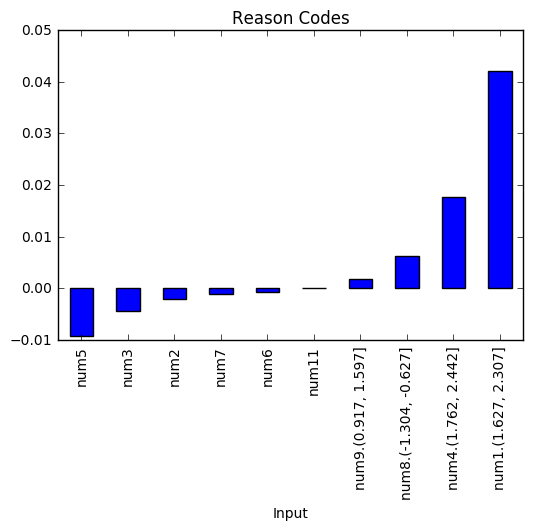

In [38]:
lime(decile)